<div style="padding:20px;
            color:white;
            margin:10;
            font-size:200%;
            text-align:center;
            display:fill;
            border-radius:5px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700">🦜 RAG: Multi Vector Retriever 🔧</div>

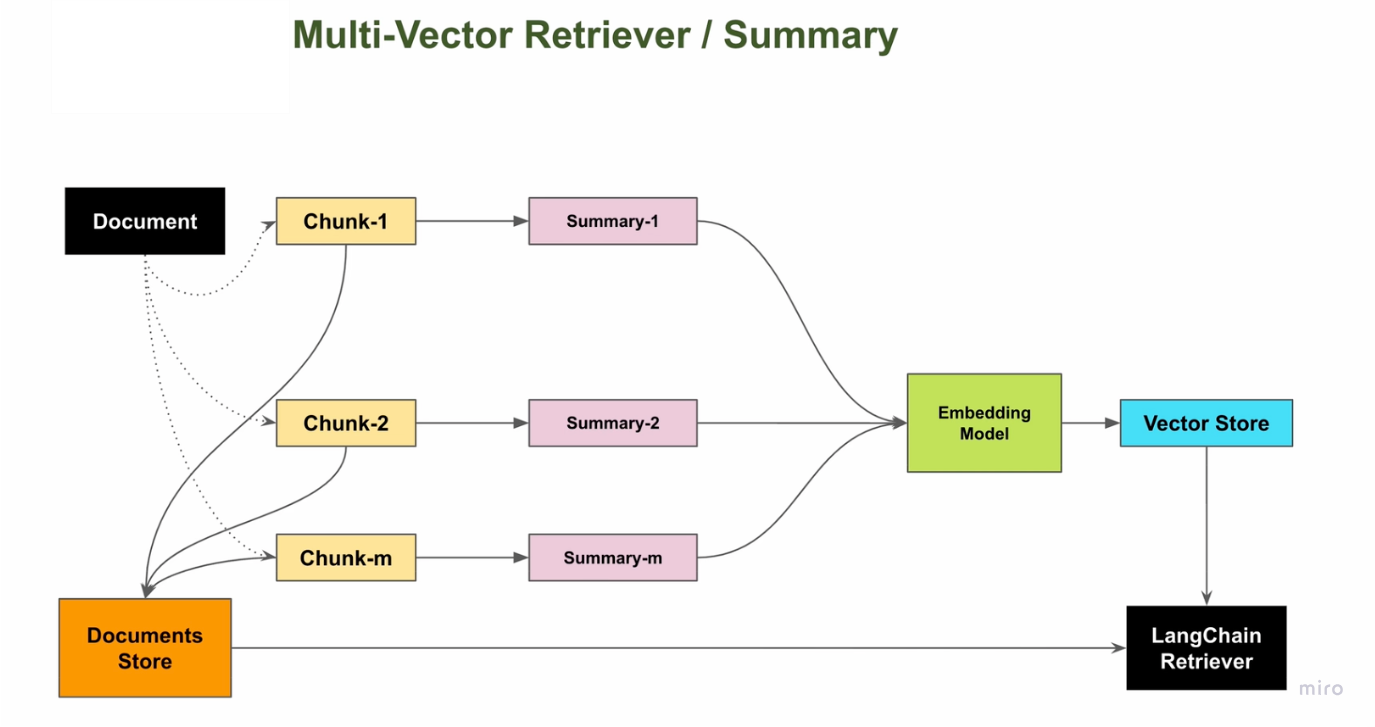

<a id="1"></a>
<div style="padding:20px;
            color:white;
            margin:10;
            font-size:150%;
            text-align:left;
            display:fill;
            border-radius:5px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700">1 <span style='color:#CDA63A'>|</span> Introduction</div>

The Multi-Vector Retriever is an advanced tool used in Retrieval-Augmented Generation (RAG) systems to enhance document retrieval by leveraging multiple vectors per document. This approach decouples the document used for answer synthesis from the reference used for retrieval, allowing for more effective and contextually rich information retrieval.

Key methods to create multiple vectors per document include:

- Smaller Chunks: Splitting a document into smaller, more manageable chunks and embedding these for detailed similarity searches.
- Summaries: Creating summaries of documents and embedding these summaries to facilitate quick and accurate retrieval.
- Hypothetical Questions: Generating hypothetical questions that a document can answer and embedding these alongside the document. This approach aids in retrieving documents based on potential queries they might address.

The Multi-Vector Retriever is beneficial because it supports diverse data types beyond plain text, including tables and images. For instance, it can generate and embed summaries of tables and image descriptions, allowing these elements to be effectively used in RAG pipelines. When a user query matches a summary, the full document (or image/table) is retrieved and passed to a Language Model (LLM) for detailed answer synthesis, ensuring no context is lost.

Implementing a Multi-Vector Retriever involves several steps:

1. Document Partitioning: Tools like Unstructured are used to extract and partition different elements (text, tables, images) from documents.
2. Vector Store Creation: Using vector databases like Chroma to store embeddings and an in-memory document store to keep the original documents.
3. Retrieval Setup: Employing LangChain’s Multi-Vector Retriever, which integrates with various embedding models and document loaders to enable effective querying.

This system can handle semi-structured and multi-modal data, making it versatile for applications involving diverse data formats, such as PDFs containing both text and tables, or documents with embedded images.

In [ ]:
!pip install langchain langchain-community langchain_openai pdfplumber chromadb

<a id="2"></a>
<div style="padding:20px;
            color:white;
            margin:10;
            font-size:150%;
            text-align:left;
            display:fill;
            border-radius:5px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700">2 <span style='color:#CDA63A'>|</span> Set-up</div>

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, PromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain_core.output_parsers import StrOutputParser
from langchain.chains.summarize import load_summarize_chain
from langchain.document_loaders import WebBaseLoader
from langchain_openai import OpenAIEmbeddings
from langchain.schema.document import Document
from langchain.storage import InMemoryStore
from langchain_openai import ChatOpenAI
from langchain.vectorstores import Chroma
import pdfplumber
import uuid
import os

In [ ]:
# Loading OPENAI_API_KEY and TAVILY_API_KEY from environment variables
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
openai_api_key = user_secrets.get_secret("OPENAI_API_KEY")

In [ ]:
# Function to check if the API key is valid
def is_key_valid(key):
    return key is not None and key.strip() != ""

# Initialize the UserSecretsClient
user_secrets = UserSecretsClient()

# Loading the OPENAI_API_KEY from the Kaggle user's secrets
OPENAI_API_KEY = user_secrets.get_secret("OPENAI_API_KEY")
if is_key_valid(OPENAI_API_KEY):
    print("OpenAI API key loaded successfully.")
else:
    print("Failed to load OpenAI API key or the key is invalid.")

In [ ]:
# Get your LLM and summarize chain going
gpt4o = ChatOpenAI(temperature=0, model_name="gpt-4o", api_key=OPENAI_API_KEY)
gpt35T = ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo", api_key=OPENAI_API_KEY)

<a id="3"></a>
<div style="padding:20px;
            color:white;
            margin:10;
            font-size:150%;
            text-align:left;
            display:fill;
            border-radius:5px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700">3 <span style='color:#CDA63A'>|</span> Preparing Documents</div>

In [ ]:
class Document:
    def __init__(self, content, metadata=None):
        self.page_content = content
        self.metadata = metadata if metadata is not None else {}
"""
A class is like a blueprint for creating objects. 
An object is a collection of data (variables) and methods (functions) 
that act on the data. For example, a Document class can be used 
to create Document objects, each with its own content and metadata.
"""

In [ ]:
# Load selected document

def load_single_document(file_path):
    # Print the start of the document loading process
    print(f"Starting to load document from {file_path}")
    
    if os.path.exists(file_path) and file_path.endswith(".pdf"):
        # Print the filename of the PDF being processed
        filename = os.path.basename(file_path)
        print(f"Loading PDF file: {filename}")
        
        with pdfplumber.open(file_path) as pdf:
            full_text = []
            # Print the number of pages in the PDF
            print(f"Number of pages in PDF: {len(pdf.pages)}")
            
            for page_number, page in enumerate(pdf.pages, start=1):
                page_text = page.extract_text()
                if page_text:
                    full_text.append(page_text)
                # Print confirmation for each page processed
                print(f"Processed page {page_number}/{len(pdf.pages)}")
            
            # Combine all pages' text into one string for the document
            document_text = '\n'.join(full_text)
            # Create a Document object with the content and optional metadata
            document = Document(content=document_text, metadata={'filename': filename})
            # Print that the document has been successfully created
            print(f"Created document for {filename} with {len(full_text)} pages of text.")
    else:
        print(f"File not found or is not a PDF: {file_path}")
        return None
    
    return document

In [ ]:
# Specify the path to the PDF file
file_path = '/kaggle/input/aib-domain-protocols/AIB-2019-DPIT-GSE-Domain Protocol 21-10-2019_0 (1).pdf'
document = load_single_document(file_path)  # Load the document

In [ ]:
if document:
    # Ensure docs_list is a list of Document objects
    docs_list = [document]

    # Split it up
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=7000, chunk_overlap=0)
    chunks = text_splitter.split_documents(docs_list)
else:
    print("Document could not be loaded.")

In [ ]:
# Split it up
text_splitter = RecursiveCharacterTextSplitter(chunk_size=7000, chunk_overlap=0)
chunks = text_splitter.split_documents(docs_list)

In [ ]:
print (f"Your {len(docs_list)} documents have been split into {len(chunks)} chunks")

<a id="4"></a>
<div style="padding:20px;
            color:white;
            margin:10;
            font-size:150%;
            text-align:left;
            display:fill;
            border-radius:5px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700">4 <span style='color:#CDA63A'>|</span> Summarize Chain</div>

The **load_summarize_chain** function in LangChain is a versatile tool for summarizing documents using various strategies, optimized for different contexts and document types. This function supports three primary methods for summarization: "stuff," "map_reduce," and "refine."

**Stuff Method**: This method involves combining all documents into a single prompt and passing that to a Language Model (LLM) for summarization. It is most effective when the combined document size fits within the context window of the LLM. This approach is straightforward but may not be suitable for very large datasets due to context window limitations.

**Map-Reduce Method**: The map-reduce approach is designed to handle larger documents by first summarizing smaller chunks (mapping) and then combining these summaries into a final summary (reducing). This method ensures that even extensive documents can be summarized effectively by recursively breaking down and combining information until it fits within the token limit of the LLM. This approach is highly scalable and can be customized with intermediate steps to fine-tune the summarization process.

**Refine Method**: This method generates an initial summary and then iteratively refines it by incorporating additional context from subsequent chunks of the document. It is useful when a more nuanced and detailed summary is required, as each refinement step can add more context and detail.

In [ ]:
summarize_chain = load_summarize_chain(gpt35T)

In [ ]:
# You can also customize the prompts used in these chains to fit specific requirements or languages. 

from langchain_core.prompts import PromptTemplate

prompt_template = """Write a concise summary of the following:
{text}
CONCISE SUMMARY IN POLISH:"""

PROMPT = PromptTemplate(template=prompt_template, input_variables=["text"])
summarize_chain_polish = load_summarize_chain(gpt35T, chain_type="stuff", prompt=PROMPT)

Then we will loop through each one of our chunks, get the summary of that chunk, and then add a unique identifier to both the summary document and the original document that tie them together

In [ ]:
# This line defines a key doc_id that will be used 
# in the metadata of both the original chunks and their summaries to link them together.
id_key = "doc_id"

# Initialize an empty list to store the summaries
summaries = []

# Iterate over each chunk of the document
for chunk in chunks:
    # A unique identifier is generated for each chunk using uuid.uuid4(), which ensures that each ID is unique.
    unique_id = str(uuid.uuid4())
    
    # The summarization chain is used to generate a summary for the current chunk. 
    # The invoke method processes the chunk and returns the summary.
    chunk_summary = summarize_chain.invoke([chunk])
    
    # This block checks if the result of the summarization chain is a dictionary and contains the key output_text. 
    # If so, it extracts the summary text. If not, it converts the entire result to a string.
    if isinstance(chunk_summary, dict) and 'output_text' in chunk_summary:
        chunk_summary_text = chunk_summary['output_text']
    else:
        chunk_summary_text = str(chunk_summary)
    
    # Create a new Document object for the summary with the unique ID in its metadata
    chunk_summary_document = Document(content=chunk_summary_text, metadata={id_key: unique_id})
    
    # Add the summary document to the list of summaries
    summaries.append(chunk_summary_document)
    
    # Also add the unique ID to the metadata of the original chunk
    # This ensures that each chunk has a unique identifier that can be used to link it with its summary.
    chunk.metadata[id_key] = unique_id

# Print the number of summaries and chunks processed
print(f"You have {len(summaries)} summaries to go along with your {len(chunks)} chunks")


Let's check the summaries.

In [ ]:
# Initialize counters
total_summaries_checked = 0
string_summaries_count = 0
non_string_summaries_count = 0

# Ensure all page_content in summaries are strings
for summary in summaries:
    total_summaries_checked += 1
    if isinstance(summary.page_content, str):
        string_summaries_count += 1
    else:
        non_string_summaries_count += 1
        print(f"Non-string content found: {summary.page_content}")

# Print the results
print(f"Total summaries checked: {total_summaries_checked}")
print(f"Number of string summaries: {string_summaries_count}")
print(f"Number of non-string summaries: {non_string_summaries_count}")

# Raise an error if there are non-string summaries
if non_string_summaries_count > 0:
    raise ValueError("Some summary contents are not strings.")

In [ ]:
selected_summary = summaries[3]

# Add newline characters for better readability (if needed)
formatted_summary = selected_summary.page_content.replace('. ', '.\n')

# Print the formatted summary
print(f"Summary of the selected chunk:\n{formatted_summary}")

In [ ]:
# Function to add newlines after periods for better readability
def format_text(text):
    return text.replace('. ', '.\n')

# Select a summary to print along with its original document chunk
selected_id = summaries[3].metadata[id_key]
selected_summary = next((summary for summary in summaries if summary.metadata[id_key] == selected_id), None)
selected_chunk = next((chunk for chunk in chunks if chunk.metadata[id_key] == selected_id), None)

if selected_summary and selected_chunk:
    print(f"Summary for Chunk ID: {selected_id}:\n")
    print(format_text(selected_summary.page_content))
    print(f"\nSummary Metadata: {selected_summary.metadata}\n")
    
    print(f"Original Document Chunk for ID: {selected_id}:\n")
    print(format_text(selected_chunk.page_content))
    # print(f"\nOriginal Document Metadata: {selected_chunk.metadata}\n")
else:
    print(f"No summary or original document found for Chunk ID: {selected_id}")

<a id="5"></a>
<div style="padding:20px;
            color:white;
            margin:10;
            font-size:150%;
            text-align:left;
            display:fill;
            border-radius:5px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700">5 <span style='color:#CDA63A'>|</span> Embeddings</div>

In [ ]:
embedding = OpenAIEmbeddings(model="text-embedding-3-large", api_key=OPENAI_API_KEY)

# The vectorstore to use to index the summary chunks
vectorstore = Chroma(collection_name="summaries", embedding_function=embedding)
# The storage layer for the parent documents
docstore = InMemoryStore()

**vectorstore**: when you query the retriever, it first looks into the vectorstore to find the vectors that are closest to the query's vector.

**docstore**: after identifying relevant vectors in the vectorstore, the retriever uses the docstore to fetch the actual documents corresponding to those vectors.

InMemoryStore serves as the storage layer for the parent documents. This means that while the vector store handles the embeddings and their efficient retrieval, InMemoryStore keeps the actual content of the documents in memory. When a summary chunk is retrieved from the vector store based on a query, the corresponding full document can be fetched from the InMemoryStore.

The id_key acts like a primary key in a database; it uniquely identifies each entry (document) and ensures that the embeddings in the vectorstore correspond correctly to the documents in the docstore. When a similarity search finds relevant vectors, it retrieves the documents using this id_key.

<a id="6"></a>
<div style="padding:20px;
            color:white;
            margin:10;
            font-size:150%;
            text-align:left;
            display:fill;
            border-radius:5px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700">6 <span style='color:#CDA63A'>|</span> Multi Vector Retriever</div>

## Workflow

**Query Processing**: When a query is received, its text is first converted into a vector using the same embedding model that was used to create the vectors in the vectorstore.

**Vector Search**: The query vector is then compared against the vectors in the vectorstore to find the most similar vectors.

**Document Retrieval**: Using the identifiers (id_key) of these similar vectors, the actual documents are fetched from the docstore.

**Result**: The documents are then returned as the search results, typically sorted by their relevance (similarity) to the query.

In [ ]:
# The retriever
# This object is part of the LangChain library and is designed to facilitate document retrieval based on vector similarity. 
# It combines the functionalities of both a vector store and a document store, linked by an identifier key.

retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=docstore,
    id_key=id_key, # This is the key used to join or link the data between the vectorstore and the docstore. Essentially, it's the unique identifier for each document across both stores.
)

In [ ]:
# Add your summary docs (with their ids) to the vectorstore
try:
    retriever.vectorstore.add_documents(summaries)
except TypeError as e:
    print(f"Error adding documents: {e}")

In [ ]:
# Perform a similarity search
_similar_docs = retriever.vectorstore.similarity_search("What are the principles of GO cancellation?")

# Print the number of documents retrieved
print(f"Number of Summaries retrieved: {len(_similar_docs)}")
print("---------------------------------")

# Print the content and metadata of each retrieved summary document
for i, doc in enumerate(_similar_docs):
    print(f"Summary {i+1} Content:\n{doc.page_content}\n")
    print(f"Summary {i+1} Metadata: {doc.metadata}\n")

But we don't want the summaries returned, but the original documents that are associated with the summaries.

In [ ]:
# Storing each chunk of your documents in the document store (docstore) with a unique identifier.
retriever.docstore.mset([(x.metadata[id_key], x) for x in chunks])

1. The list comprehension iterates over each chunk in chunks.
2. For each chunk (x), it creates a tuple:
- The first element of the tuple is the unique ID of the chunk (x.metadata[id_key]).
- The second element is the chunk itself (x).

**mset** is a method that sets multiple key-value pairs in the document store.

- The argument provided to mset is a list of tuples. Each tuple contains a unique ID and the corresponding document chunk.

This method ensures that each chunk is stored in the docstore with its unique ID as the key.

In [ ]:
# Testing
retrieved_docs = retriever.invoke("What are the principles of GO cancellation?")

# Print the content and metadata of the first retrieved document
print(retrieved_docs[0].page_content[:1500])
print(retrieved_docs[0].metadata)


<a id="7"></a>
<div style="padding:20px;
            color:white;
            margin:10;
            font-size:150%;
            text-align:left;
            display:fill;
            border-radius:5px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700">7 <span style='color:#CDA63A'>|</span> Result</div>

In [ ]:
def format_docs(chunks):
    """
    This function creates a rich context string for each document, including all available metadata.
    """
    formatted_chunks = []
    for chunk in chunks:
        # Initialize the document text with metadata. Skip 'content' since it's handled separately.
        chunk_text_parts = [f"{key.capitalize()}: {value}" for key, value in chunk.metadata.items() if key != 'content']
        # Add the content at the end
        chunk_text_parts.append(f"Content:\n{chunk.page_content}")
        # Join all parts with newlines and add to the list
        formatted_chunks.append("\n".join(chunk_text_parts))
    return "\n\n".join(formatted_chunks)


In [ ]:
retrieved_docs = retriever.invoke("What are the principles of GO cancellation?")
final_string = format_docs(retrieved_docs)

In [ ]:
# Define the human message prompt template
human_message_template = PromptTemplate.from_template(
    """
    You are an experienced assistant specializing in question-answering tasks. 
    Utilize the provided context to respond to the question. 
    If the answer is unknown, always state 'I don't know.' 
    Never provide an answer you are unsure about and ensure it is concise.
    \nQuestion: {question} \nContext: {context} \nAnswer:
    """
)

# Create a HumanMessagePromptTemplate instance using the defined prompt template
human_message_prompt_template = HumanMessagePromptTemplate(prompt=human_message_template)

# Create the ChatPromptTemplate with the input variables and messages, excluding metadata
chat_prompt_template = ChatPromptTemplate(
    input_variables=['context', 'question'],
    messages=[human_message_prompt_template]
)

In [ ]:
rag_chain = chat_prompt_template | gpt4o | StrOutputParser()
generation = rag_chain.invoke({"context": final_string, "question": "What are the principles of GO cancellation in Italy?"})

In [ ]:
print(generation)

<a id="8"></a>
<div style="padding:20px;
            color:white;
            margin:10;
            font-size:150%;
            text-align:left;
            display:fill;
            border-radius:5px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700">8 <span style='color:#CDA63A'>|</span> Collection of my notebooks for your enjoyment</div>

RAG: Stop Prompting & Start Programming: DSPy
* [Stop Prompting & Start Programming: DSPy Examples](https://www.kaggle.com/code/marcinrutecki/stop-prompting-start-programming-dspy-examples)
* [Stop Prompting & Start Programming: DSPy Signatures](https://www.kaggle.com/code/marcinrutecki/stop-prompting-start-programming-dspy-signature)

RAG: LangGraph:
* [LangGraph Simplified](https://www.kaggle.com/code/marcinrutecki/langgraph-simplified)

AI Search Engines:
* [AI Crew Streamlines Next-Gen Research Process](https://www.kaggle.com/code/marcinrutecki/ai-crew-streamlines-next-gen-research-process)
* [LLM Enhanced Web Search: The Tavily & Lang Chain](https://www.kaggle.com/code/marcinrutecki/llm-enhanced-web-search-the-tavily-lang-chain)

LangChain
* [LangChain: Multiple chains simply Explained](https://www.kaggle.com/code/marcinrutecki/langchain-multiple-chains-simply-explained)

Image Generation
* [Face Image Enhance Upscale With GFPGAN Explained](https://www.kaggle.com/code/marcinrutecki/face-image-enhance-upscale-with-gfpgan-explained)
* [Stable Diffusion XL Hugging Face API Explained](https://www.kaggle.com/code/marcinrutecki/stable-diffusion-xl-hugging-face-api-explained)

ML Principles
* [One Hot Encoding - everything you need to know](https://www.kaggle.com/code/marcinrutecki/one-hot-encoding-everything-you-need-to-know)
* [Stacking classifier - ensemble for great results](https://www.kaggle.com/code/marcinrutecki/stacking-classifier-ensemble-for-great-results)
* [How to create a meaningful EDA](https://www.kaggle.com/code/marcinrutecki/how-to-create-a-meaningful-eda)
* [GridSearchCV + KFold CV: The Right Way](https://www.kaggle.com/code/marcinrutecki/gridsearchcv-kfold-cv-the-right-way)
* [Voting Classifier for Better Results](https://www.kaggle.com/code/marcinrutecki/voting-classifier-for-better-results)
* [SMOTE and Tomek Links for imbalanced data](https://www.kaggle.com/code/marcinrutecki/smote-and-tomek-links-for-imbalanced-data)
* [Best techniques and metrics for Imbalanced Dataset](https://www.kaggle.com/code/marcinrutecki/best-techniques-and-metrics-for-imbalanced-dataset)
* [Regression Models Evaluation Metrics](https://www.kaggle.com/code/marcinrutecki/regression-models-evaluation-metrics)
* [Clustering methods - comprehensive study](https://www.kaggle.com/code/marcinrutecki/clustering-methods-comprehensive-study)
* [Outlier detection methods!](https://www.kaggle.com/code/marcinrutecki/outlier-detection-methods)
* [Multicollinearity - detection and remedies](https://www.kaggle.com/code/marcinrutecki/multicollinearity-detection-and-remedies)
* [Standardize or Normalize - Ultimate Answer](https://www.kaggle.com/code/marcinrutecki/standardize-or-normalize-ultimate-answer)